<a href="https://colab.research.google.com/github/Ftihochou/Ftihochou.github.io/blob/main/MEP_Fish_Allergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.0 MB/s eta 0:00:00


In [3]:
from Bio import SeqIO  # Import Biopython's SeqIO module

# Path to your uploaded FASTA file
fasta_file = "/content/Official fish parvalbumins for ML.fasta"

# Parse the FASTA file
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    print(f"ID: {record.id}")  # Print sequence ID
    print(f"Sequence: {record.seq[:50]}...")  # Print first 50 characters of the sequence
    sequences.append({"id": record.id, "sequence": str(record.seq)})

print(f"Total sequences loaded: {len(sequences)}")

ID: tr|E0WDA1|E0WDA1_CLUHA
Sequence: MAFAAFLKEADITAALGACKGADSFDHKAFFAKVGLKGKSGDELKKAFEI...
ID: tr|E0WDA6|E0WDA6_CLUHA
Sequence: MAFAGLLSDADIAAALGACTAADTFDHKSFFKEVGLSGKSADDVKKAFYI...
ID: tr|C6GKU6|C6GKU6_CLUHA
Sequence: MALASLLKGADIDAALKACEAKDSFKHKDFFAKIGLATKSAADLKKAFEI...
ID: tr|C6GKU7|C6GKU7_CLUHA
Sequence: MAFAGLLSDADIAAALGACTAADTFDHKSFFKKVGLSGKSADDVKKPFYI...
ID: tr|C6GKU8|C6GKU8_CLUHA
Sequence: MAFAAFLKEADITAALGACKGADSFDHKAFFAKVGLKGKSGDELKKAFEI...
ID: tr|E0WDA7|E0WDA7_CLUHA
Sequence: KDSFKHKDFFAKIGLATKSAADLKKAFEIIDQDKSGFIEEEELKLFLQNF...
ID: tr|B3WFF7|B3WFF7_9TELE
Sequence: MALAGLVKEADITAALEACKAADSFDHKAFFHKVGMSGKSADELKKAFAI...
ID: tr|E0WD92|E0WD92_CYPCA
Sequence: MAFAGILNDADITAALQGCKAADSFDYKSFFAKVGLSAKTPDDIKKAFAV...
ID: sp|P09227|PRVA_CYPCA
Sequence: MAYGGILNDADITAALEACXAXDSFNAKSFFAKVGLSAKTPDDIKKAFAV...
ID: tr|E0WD93|E0WD93_CYPCA
Sequence: MAFAGVLNDADIAAALEACKAADSFNHKAFFAKVGLTSKSADDVKKAFAI...
ID: sp|P02618|PRVB_CYPCA
Sequence: AFAGVLNDADIAAALEACKAADSFNHKAFFAKVGLTSKSADDVKKAFAII...
ID:

In [4]:
# Save processed data to a new file
import csv

output_file = "/content/processed_sequences.csv"
with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "Sequence"])  # Header
    for seq in sequences:
        writer.writerow([seq["id"], seq["sequence"]])

print(f"Processed data saved to: {output_file}")


Processed data saved to: /content/processed_sequences.csv


In [5]:
# Function to fragment sequences using a sliding window
def generate_fragments(sequence, window_size=15, step=1):
    fragments = []
    for i in range(0, len(sequence) - window_size + 1, step):
        fragments.append(sequence[i:i + window_size])
    return fragments

# Apply sliding window to all sequences
window_size = 15  # You can adjust this size
step_size = 1
all_fragments = []  # To store all fragments
for seq in sequences:
    fragments = generate_fragments(seq["sequence"], window_size, step_size)
    all_fragments.extend(fragments)

print(f"Total fragments generated: {len(all_fragments)}")
print(f"Example fragment: {all_fragments[0]}")


Total fragments generated: 6668
Example fragment: MAFAAFLKEADITAA


In [6]:
import random

# Assign random labels (replace this with real labels later)
labels = [random.choice([0, 1]) for _ in all_fragments]

# Combine fragments with labels
labeled_data = [{"fragment": frag, "label": label} for frag, label in zip(all_fragments, labels)]
print(f"First labeled fragment: {labeled_data[0]}")


First labeled fragment: {'fragment': 'MAFAAFLKEADITAA', 'label': 0}


In [7]:
import numpy as np

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

def one_hot_encode(sequence):
    encoding = np.zeros((len(sequence), len(amino_acids)))
    for i, aa in enumerate(sequence):
        if aa in amino_acids:
            encoding[i][amino_acids.index(aa)] = 1
    return encoding.flatten()  # Flatten to a single vector

# Example: Encode a single fragment
example_encoding = one_hot_encode(all_fragments[0])
print(f"One-hot encoding shape: {example_encoding.shape}")


One-hot encoding shape: (300,)


In [8]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def calculate_physicochemical(sequence):
    analysis = ProteinAnalysis(sequence)
    return [
        analysis.molecular_weight(),
        analysis.aromaticity(),
        analysis.isoelectric_point(),
        analysis.instability_index(),
        analysis.gravy(),  # Hydrophobicity
    ]

# Example: Extract features for a single fragment
example_features = calculate_physicochemical(all_fragments[0])
print(f"Physicochemical features: {example_features}")


Physicochemical features: [1569.8191000000002, 0.13333333333333333, 4.369065666198731, 6.239999999999999, 1.0000000000000004]


In [9]:
# Example: Create feature matrix (X) and label vector (y)
X = [one_hot_encode(frag) for frag in all_fragments]  # Feature vectors
y = labels  # Labels

X = np.array(X)
y = np.array(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Feature matrix shape: (6668, 300)
Labels shape: (6668,)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.49      0.49       653
           1       0.50      0.49      0.50       681

    accuracy                           0.49      1334
   macro avg       0.49      0.49      0.49      1334
weighted avg       0.49      0.49      0.49      1334



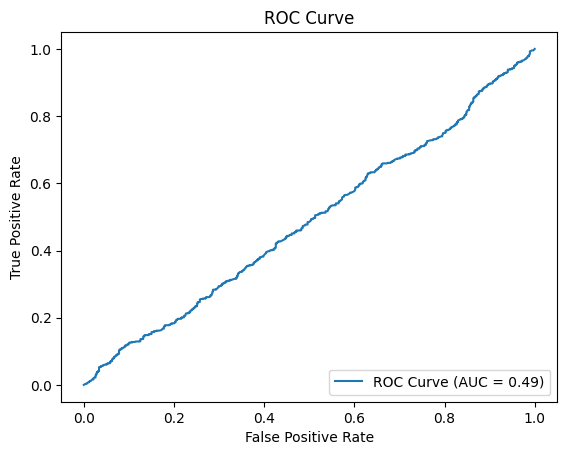

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate and plot the ROC curve
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()


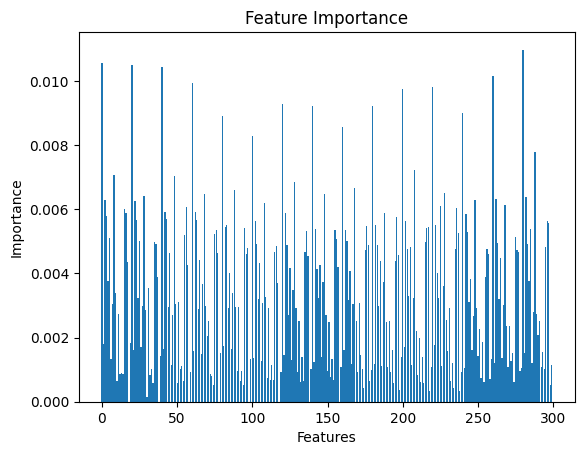

In [12]:
# Get feature importance
importances = rf_model.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


In [13]:
# Get probabilities for the positive class
y_probs = rf_model.predict_proba(X)[:, 1]

# Filter fragments with high probabilities
threshold = 0.9  # Example: Top 10%
top_epitopes = [(frag, prob) for frag, prob in zip(all_fragments, y_probs) if prob > threshold]

print(f"Number of top epitopes: {len(top_epitopes)}")
for epitope, prob in top_epitopes[:5]:  # Display top 5
    print(f"Epitope: {epitope}, Probability: {prob}")


Number of top epitopes: 464
Epitope: DITAALGACKGADSF, Probability: 0.97
Epitope: DSFDHKAFFAKVGLK, Probability: 0.95
Epitope: KAFFAKVGLKGKSGD, Probability: 0.9386428571428571
Epitope: KVGLKGKSGDELKKA, Probability: 0.96
Epitope: LKGKSGDELKKAFEI, Probability: 0.958030303030303
